# Downloading and processing geometry

More information available at [documentation](https://denikozub.github.io/Offroad-routing-engine/#geometry).

There are several ways to obtain OSM data:
* specify .xml (.osm) file to be parsed
* specify .osm.pbf file to be parsed (resources: [parts of the world](https://download.geofabrik.de/), [cities](https://download.bbbike.org/osm/bbbike/), [adjustable area](https://extract.bbbike.org/) (via mail), [adjustable area](https://export.hotosm.org/en/v3/) (online), [planet](https://planet.maps.mail.ru/pbf/))
* specify bounding box for map data to be dowloaded and parsed
* specify [region / city / country](https://pyrosm.readthedocs.io/en/latest/basics.html#protobuf-file-what-is-it-and-how-to-get-one) query for map data to be dowloaded and parsed

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from offroad_routing import Geometry

filename = "../maps/user_area.osm.pbf"
bbox = [34, 59, 34.2, 59.1]
geom = Geometry.parse(filename=filename, bbox=bbox)

Geometry data can be explored and visualized using folium, which allows multiple maps to be combined in one layer:

In [3]:
geom.stats

{'number_of_polygons': 35,
 'number_of_edges': 739,
 'number_of_nodes': 739,
 'road_length_km': 54.69698300000001,
 'polygon_tags': {'heath', 'wetland', 'wood'},
 'road_tags': {'path', 'road', 'tertiary', 'track', 'unclassified'}}

In [4]:
geom.plot()

Geometry can be cut to a bounding box, if needed:

In [5]:
geom.cut_bbox([34.01, 59.01, 34.19, 59.09])

Road network geometry can be simplified and visualized separately. Available options:
* remove small edges using edge contraction
* build minimum spanning tree
* select specific road surface types

In [6]:
geom.select_road_type({'path'}, exclude=True, inplace=True)
geom.minimum_spanning_tree(inplace=True)
geom.simplify_roads(100, inplace=True)

In [7]:
geom.plot('roads')

Polygon geometry can also be simplified and visualized separately, small polygons will be removed:

In [8]:
geom.simplify_polygons(15, inplace=True)

In [9]:
poly_map = geom.plot('polygons')
poly_map

Geometry can be saved to file and loaded afterwards using Geometry.load():

In [10]:
geom.save('new_map', '../maps')

# Building visibility graph

More information available at [documentation](https://denikozub.github.io/Offroad-routing-engine/#visibilitygraph).

VisibilityGraph uses speciad geometry representation for maximum speed, so processed geometry needs to be exported:

In [11]:
from offroad_routing import VisibilityGraph

geom = Geometry.load('user_area', '../maps')
vgraph = VisibilityGraph(*geom.export())

Even though vgraph can be used to find routes without pre-building whole graph,  
visibility graph can be fully built and saved to memory for further use:

In [13]:
vgraph.build(inside_percent=0, multiprocessing=False)

In [14]:
vgraph.stats

{'number_of_polygons': 10,
 'number_of_road_segments': 137,
 'number_of_edges': 3981,
 'number_of_nodes': 384}

Visibility graph can also be visualised using folium:

In [15]:
vgraph.plot(graph_map=poly_map)

Pre-built graph can be exported to networkx.MultiGraph and used for further analysis:

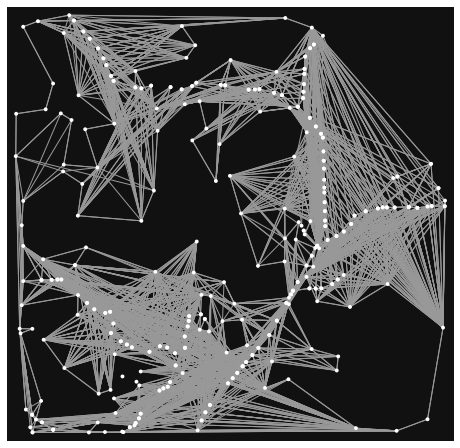

In [16]:
import osmnx as ox

G = vgraph.graph
ox.plot_graph(G);

# Building routes

More information available at [documentation](https://denikozub.github.io/Offroad-routing-engine/#astar)

If vgraph.build() had been run, pre-built graph is used for pathfinding.  
Otherwise, incident vertices are computed at runtime, which allows to explore less graph nodes (in combination with A*)

In [17]:
from offroad_routing import AStar

pathfinder = AStar(vgraph)
path = pathfinder.find((34.02, 59.01), (34.12, 59.09), heuristic_multiplier=10)

Path can be viewed in coordinate format:

In [18]:
print(path.path)

[(34.02, 59.01), (34.0228613, 59.0155847), (34.0542262, 59.0205355), (34.062423, 59.0194862), (34.067251, 59.0208116), (34.0706628, 59.0204913), (34.0742677, 59.0191217), (34.0789455, 59.0204251), (34.0788167, 59.023142), (34.08019, 59.0255274), (34.0806835, 59.0268747), (34.0808766, 59.0280121), (34.0866065, 59.0330808), (34.0909624, 59.0328047), (34.1216469, 59.0269194), (34.1260579, 59.0311541), (34.1282357, 59.0332021), (34.1291668, 59.0340904), (34.1313256, 59.0361499), (34.135467, 59.040102), (34.1379346, 59.042431), (34.1404237, 59.0448262), (34.1441788, 59.0495277), (34.144093, 59.0508519), (34.1440071, 59.0531251), (34.1438998, 59.0552437), (34.1437926, 59.0575827), (34.1437711, 59.0587522), (34.1437067, 59.0606388), (34.143578, 59.0632974), (34.1434492, 59.0651726), (34.1433849, 59.0674007), (34.1430844, 59.0706985), (34.1422047, 59.0716249), (34.1398014, 59.0733674), (34.1370119, 59.0754295), (34.1313877, 59.0780965), (34.1240796, 59.0808342), (34.1203645, 59.0814202), (34.1

More information available at [documentation](https://denikozub.github.io/Offroad-routing-engine/#gpxtrack)

However, specialized tools can be used to save and visualize the path:  
The following code saves the path to a gpx file and generates a link to view it online.

In [19]:
from offroad_routing import GpxTrack

track = GpxTrack(path)
track.write_file("track.gpx")
track.visualize()

Go to website: https://nakarte.me/#nktj=W3sibiI6ICIyMDIyLTA0LTE2IiwgInAiOiBbeyJuIjogIlN0YXJ0IiwgImx0IjogNTkuMDEsICJsbiI6IDM0LjAyfSwgeyJuIjogIkdvYWwiLCAibHQiOiA1OS4wOSwgImxuIjogMzQuMTJ9XSwgInQiOiBbW1s1OS4wMSwgMzQuMDJdLCBbNTkuMDE1NTg0NywgMzQuMDIyODYxM10sIFs1OS4wMjA1MzU1LCAzNC4wNTQyMjYyXSwgWzU5LjAxOTQ4NjIsIDM0LjA2MjQyM10sIFs1OS4wMjA4MTE2LCAzNC4wNjcyNTFdLCBbNTkuMDIwNDkxMywgMzQuMDcwNjYyOF0sIFs1OS4wMTkxMjE3LCAzNC4wNzQyNjc3XSwgWzU5LjAyMDQyNTEsIDM0LjA3ODk0NTVdLCBbNTkuMDIzMTQyLCAzNC4wNzg4MTY3XSwgWzU5LjAyNTUyNzQsIDM0LjA4MDE5XSwgWzU5LjAyNjg3NDcsIDM0LjA4MDY4MzVdLCBbNTkuMDI4MDEyMSwgMzQuMDgwODc2Nl0sIFs1OS4wMzMwODA4LCAzNC4wODY2MDY1XSwgWzU5LjAzMjgwNDcsIDM0LjA5MDk2MjRdLCBbNTkuMDI2OTE5NCwgMzQuMTIxNjQ2OV0sIFs1OS4wMzExNTQxLCAzNC4xMjYwNTc5XSwgWzU5LjAzMzIwMjEsIDM0LjEyODIzNTddLCBbNTkuMDM0MDkwNCwgMzQuMTI5MTY2OF0sIFs1OS4wMzYxNDk5LCAzNC4xMzEzMjU2XSwgWzU5LjA0MDEwMiwgMzQuMTM1NDY3XSwgWzU5LjA0MjQzMSwgMzQuMTM3OTM0Nl0sIFs1OS4wNDQ4MjYyLCAzNC4xNDA0MjM3XSwgWzU5LjA0OTUyNzcsIDM0LjE0NDE3ODhdLCBbNTkuMDUwODUxOSwgMzQuMTQ0MDkz

Path can also be visualized using folium and combibed with other maps:

In [20]:
track.plot()